In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh#

import module.geometry.metric as metric
import module.geometry.christoffel as christoffel
import module.misc.tree_util as tree_util

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
# Define a grid
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


In [4]:
all_states = jnp.array([s for s in hi.states()])

## Construct Neural Network

In [5]:
def act(x):
    return netket.nn.activation.log_cosh(x)

In [6]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16, name="dense1", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = jnp.sum(x, axis = -1)

        return jnp.squeeze(x)

## Construct Ansatz

In [7]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (g.n_nodes,))

        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((g.n_nodes,)))

        return {"nn": nn_param}
    
    
    def calc_logpsi(self, parameters, x):
        logpsi = self.nn.apply(parameters["nn"], x)

        return logpsi

In [8]:
ansatz = Ansatz()

## Sampler

In [9]:
class FlipSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mask = jnp.ones((g.n_nodes))
        for i in range(self.variance):
            index = jax.random.randint(key, (), 0, g.n_nodes)
            key, _ = jax.random.split(key)
            mask = mask.at[index].multiply(-1)

        proposal = element * mask

        return subkey, proposal
sampler = FlipSampler(ansatz, 1)
subsampling = g.n_nodes
def get_samples(N, param):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, 2*jax.random.randint(key, (g.n_nodes,), 0, 2)-1 + 0., N*subsampling)
    return samples[0:-1:subsampling], ratio

### Covariant Norm

In [10]:
def calc_norm_square(ansatz, samples, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, metric.apply_g(ansatz, samples, primals, tangent)))

def full_calc_norm_square(ansatz, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, metric.full_apply_g(ansatz, primals, tangent, all_states)))

## Geodesics
We try to first accurately simulate geodesic motion on the variational manifold. Therefore, we discretise the geodesic equation and obtain:
$$
\gamma^i(t + \epsilon) = 2\gamma(t)^i  - \gamma^i(t-\epsilon) - \Gamma^i_{jk}(\gamma^j(t)-\gamma^j(t-\epsilon))(\gamma^k(t)-\gamma^k(t-\epsilon))
$$

In [11]:
def full_geodesic(param, param_dot, N = 10, epsilon = 0.01):
    stats = {"momentum":[], "test": []}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):
        delta_param = tree_util.t_sub(param, old_param)
        param_dot = tree_util.s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = metric.full_inverse_g(ansatz, param, christoffel.full_geodesic_correction(ansatz, param, delta_param, all_states), all_states)

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = tree_util.t_sub(param, old_param)
        param_dot = tree_util.s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = metric.inverse_g(ansatz, samples, param, christoffel.geodesic_correction(ansatz, samples, param, delta_param))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - cor, param, old_param, cor)
        old_param = param
        param = new_param



    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


def geodesic_approx(param, param_dot, N = 10, epsilon = 0.01, N_samples = 5000):
    stats = {"momentum":[]}

    old_param = jax.tree_util.tree_map(lambda a, b: a - epsilon*b, param, param_dot)
    old_samples, _ = get_samples(N_samples, old_param)

    for i in tqdm(range(N)):

        samples, _ = get_samples(N_samples, param)
        delta_param = tree_util.t_sub(param, old_param)
        param_dot = tree_util.s_mul(1/epsilon, delta_param)
        ## 2-norm of a pytree
        stats["momentum"].append(full_calc_norm_square(ansatz, param, param_dot))

        cor = metric.inverse_g(ansatz, samples, param, christoffel.geodesic_correction_approx(ansatz, samples, old_samples, param, old_param, param_dot, epsilon))

        # update
        new_param = jax.tree_util.tree_map(lambda par, oldpar, cor: 2*par - oldpar - epsilon**2*cor, param, old_param, cor)
        old_param = param
        param = new_param

        old_samples = samples

    numpy_stats = {}
    for key_ in stats.keys():
        numpy_stats[key_] = np.array(stats[key_])

    return numpy_stats


In [22]:
key, _ = jax.random.split(key)
param = ansatz.init_param(key)
N = 50
epsilon = 0.01

param_dot = tree_util.s_mul(0.01, tree_util.t_ones_like(param))
init_norm = full_calc_norm_square(ansatz, param, param_dot)

full_stats = full_geodesic(param, param_dot , N, epsilon)
stats = geodesic(param, param_dot, N, epsilon, N_samples=5000)
stats_approx = geodesic_approx(param, param_dot, N, epsilon, N_samples=5000)

100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


In [13]:
# np.savetxt("full_stats_eps=1e-2", full_stats["momentum"])
# np.savetxt("stats_eps=1e-2", stats["momentum"])
# np.savetxt("stats_approx_eps=1e-2", stats_approx["momentum"])

## Evaluate accuracy

Text(0.5, 1.0, 'deviation from geodesic in full summation and sampling epsilon=0.01')

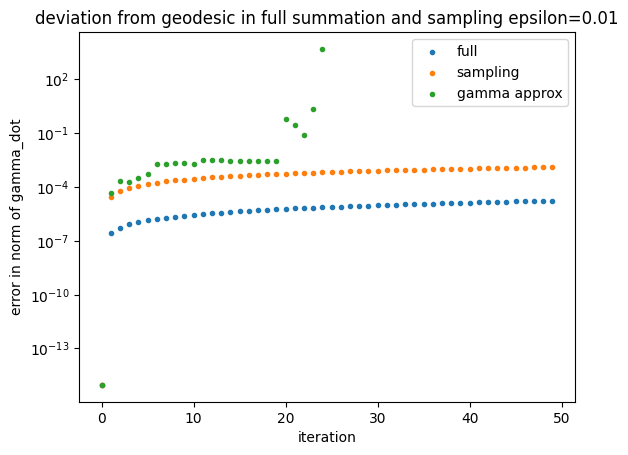

In [23]:
i = jnp.arange(N)

plt.scatter(i, jnp.abs(full_stats["momentum"] - init_norm), label = "full", marker = ".")
plt.scatter(i, jnp.abs(stats["momentum"] - init_norm), label = "sampling", marker =".")
plt.scatter(i, jnp.abs(stats_approx["momentum"] - init_norm), label = "gamma approx", marker =".")

plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("error in norm of gamma_dot")
plt.legend()
plt.title("deviation from geodesic in full summation and sampling epsilon="+str(epsilon))
# plt.ylim(0, 0.01)


In [20]:
key, _ = jax.random.split(key)
N_samples = 5000
param = ansatz.init_param(key)
param_dot = tree_util.s_mul(0.01, tree_util.t_ones_like(param))
samples, _ = get_samples(N_samples, param)
x2 = christoffel.geodesic_correction(ansatz, samples, param, param_dot)

errs = []
eps = 10**(-jnp.arange(20,50)*0.1 + 0.)
for epsilon in eps:
    old_param = tree_util.t_sub(param, tree_util.s_mul(epsilon, param_dot))
    old_samples, _ = get_samples(N_samples, old_param)
    x1 = christoffel.geodesic_correction_approx(ansatz, samples, old_samples, param, old_param, param_dot, epsilon)
    err = tree_util.euclid_norm_sq(tree_util.t_sub(x1, x2))
    # err = full_calc_norm_square(ansatz, param, t_sub(x1,x2))
    errs.append(jnp.sqrt(err))

Text(0.5, 1.0, 'geodesic correction error between Gamma and approximated Gamma (both sampled)')

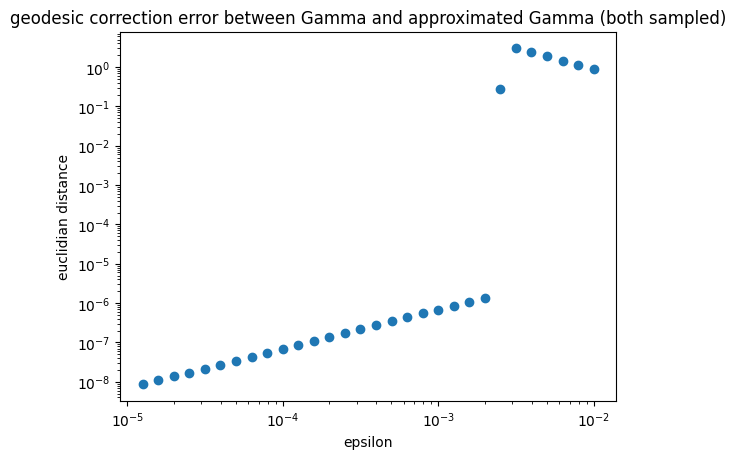

In [21]:
plt.scatter(eps, errs)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("epsilon")
plt.ylabel("euclidian distance")
plt.title("geodesic correction error between Gamma and approximated Gamma (both sampled)")

---